# Data Preparation

This notebook details the initial steps of preparing the [Vehicles.csv](https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data) dataset for analysis. It includes data loading, understanding, and cleaning processes to ensure the data is in a format for further analysis. Key tasks involve handling missing values, encoding categorical variables, normalizing numerical features, and addressing any data quality issues.

By the end of this notebook, the dataset will be transformed into a refined version ready for exploratory data anlanlysis and model development.

### Loading Tools and Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

df = pd.read_csv('../data/vehicles.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../data/vehicles.csv'

## Understanding The Data
- Dataframe `shape`
- `info`
- `head` and `tail`
- `describe`
- `unique` values

In [4]:
df.shape

NameError: name 'df' is not defined

In [2]:
df.info()

NameError: name 'df' is not defined

In [4]:
df

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,"2,019.00",nissan,maxima s sedan 4d,good,6 cylinders,gas,"32,226.00",clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.79,-84.45,2021-04-04T03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,"2,020.00",volvo,s60 t5 momentum sedan 4d,good,NaN,gas,"12,029.00",clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,NaN,wy,33.79,-84.45,2021-04-04T03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,"2,020.00",cadillac,xt4 sport suv 4d,good,NaN,diesel,"4,174.00",clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.78,-84.41,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,"2,018.00",lexus,es 350 sedan 4d,good,6 cylinders,gas,"30,112.00",clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.79,-84.45,2021-04-04T03:21:11-0600


In [5]:
df.describe()

,id,price,year,odometer,county,lat,long
count,"426,880.00","426,880.00","425,675.00","422,480.00",0.00,"420,331.00","420,331.00"
mean,"7,311,486,634.22","75,199.03","2,011.24","98,043.33",NaN,38.49,-94.75
std,"4,473,170.41","12,182,282.17",9.45,"213,881.50",NaN,5.84,18.37
min,"7,207,408,119.00",0.00,"1,900.00",0.00,NaN,-84.12,-159.83
25%,"7,308,143,339.25","5,900.00","2,008.00","37,704.00",NaN,34.60,-111.94
50%,"7,312,620,821.00","13,950.00","2,013.00","85,548.00",NaN,39.15,-88.43
75%,"7,315,253,543.50","26,485.75","2,017.00","133,542.50",NaN,42.40,-80.83
max,"7,317,101,084.00","3,736,928,711.00","2,022.00","10,000,000.00",NaN,82.39,173.89


In [6]:
unique_check = df.drop(['url', 'region', 'region_url', 'image_url', 'description'], axis=1).copy()
for column, rows in unique_check.items():
    print('----------')
    print(f'{column} --- {df[column].unique()} --- {df[column].dtype}')

----------
id --- [7222695916 7218891961 7221797935 ... 7301591147 7301591140 7301591129] --- int64
----------
price --- [ 6000 11900 21000 ...  6328 19853 17873] --- int64
----------
year --- [  nan 2014. 2010. 2020. 2017. 2013. 2012. 2016. 2019. 2011. 1992. 2018.
 2004. 2015. 2001. 2006. 1968. 2003. 2008. 2007. 2005. 1966. 2009. 1998.
 2002. 1999. 2021. 1997. 1976. 1969. 1995. 1978. 1954. 1979. 1970. 1974.
 1996. 1987. 2000. 1955. 1960. 1991. 1972. 1988. 1994. 1929. 1984. 1986.
 1989. 1973. 1946. 1933. 1958. 1937. 1985. 1957. 1953. 1942. 1963. 1977.
 1993. 1903. 1990. 1965. 1982. 1948. 1983. 1936. 1932. 1951. 1931. 1980.
 1967. 1971. 1947. 1981. 1926. 1962. 1975. 1964. 1934. 1952. 1940. 1959.
 1950. 1930. 1956. 1922. 1928. 2022. 1901. 1941. 1924. 1927. 1939. 1923.
 1949. 1961. 1935. 1918. 1900. 1938. 1913. 1916. 1943. 1925. 1921. 1915.
 1945. 1902. 1905. 1920. 1944. 1910. 1909.] --- float64
----------
manufacturer --- [nan 'gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazd

## Data Preparation
- Dropping irrelevant columns and rows
- Identifying duplicated columns / incorrect datatypes
- Impute `NaN`
- Renaming columns
- Feature creation or addressing any concerns

In [7]:
for column, row in df.items():
    print(f'{column} - {round((df[column].isna().sum() / len(df)) * 100,2)}%')
print('--------')
print(f'Shape: {df.shape}')

id - 0.0%
url - 0.0%
region - 0.0%
region_url - 0.0%
price - 0.0%
year - 0.28%
manufacturer - 4.13%
model - 1.24%
condition - 40.79%
cylinders - 41.62%
fuel - 0.71%
odometer - 1.03%
title_status - 1.93%
transmission - 0.6%
VIN - 37.73%
drive - 30.59%
size - 71.77%
type - 21.75%
paint_color - 30.5%
image_url - 0.02%
description - 0.02%
county - 100.0%
state - 0.0%
lat - 1.53%
long - 1.53%
posting_date - 0.02%
--------
Shape: (426880, 26)


In [9]:
df = df[[
    # 'id', 'url', 'region', 'region_url', 'VIN', 'size', 
    # 'county', 'lat', 'long', 'image_url', 'posting_date',
    'price', 'year', 'manufacturer', 'model', 'condition', 'odometer', 'cylinders', 'fuel', 
    'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state', 'description']]

In [10]:
for column in df.columns:
    df = df[df[column].notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115988 entries, 31 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         115988 non-null  int64  
 1   year          115988 non-null  float64
 2   manufacturer  115988 non-null  object 
 3   model         115988 non-null  object 
 4   condition     115988 non-null  object 
 5   odometer      115988 non-null  float64
 6   cylinders     115988 non-null  object 
 7   fuel          115988 non-null  object 
 8   title_status  115988 non-null  object 
 9   transmission  115988 non-null  object 
 10  drive         115988 non-null  object 
 11  type          115988 non-null  object 
 12  paint_color   115988 non-null  object 
 13  state         115988 non-null  object 
 14  description   115988 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 14.2+ MB


count     102.00
mean    1,137.14
std     2,236.31
min         1.00
25%        19.25
50%        90.00
75%       468.25
max     8,393.00
Name: count, dtype: float64


<Axes: xlabel='year'>

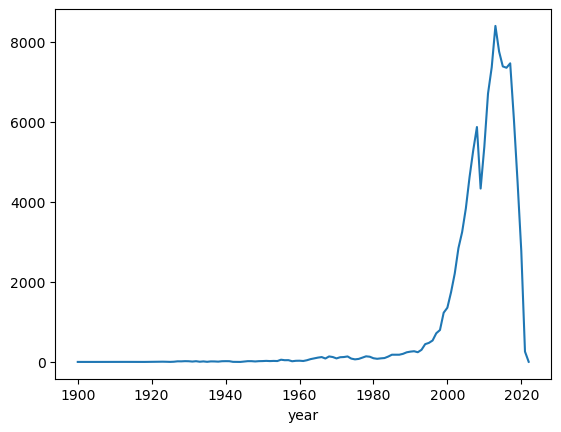

In [11]:
print(df.year.value_counts().describe())
df.year.value_counts().sort_index().plot(kind='line')

In [12]:
df = df[df['year'] >= (df['year'].max() - 30)]
df['year'] = df['year'].astype(int)
print(df['year'].value_counts().describe())
print(f'min,value_counts: {df["year"].value_counts().min()}, idxmin: {df["year"].value_counts().idxmin()}')
print('----------')
print(df.info())

count      31.00
mean    3,594.90
std     2,803.39
min         4.00
25%       757.50
50%     3,246.00
75%     5,966.50
max     8,393.00
Name: count, dtype: float64
min,value_counts: 4, idxmin: 2022
----------
<class 'pandas.core.frame.DataFrame'>
Index: 111442 entries, 31 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         111442 non-null  int64  
 1   year          111442 non-null  int64  
 2   manufacturer  111442 non-null  object 
 3   model         111442 non-null  object 
 4   condition     111442 non-null  object 
 5   odometer      111442 non-null  float64
 6   cylinders     111442 non-null  object 
 7   fuel          111442 non-null  object 
 8   title_status  111442 non-null  object 
 9   transmission  111442 non-null  object 
 10  drive         111442 non-null  object 
 11  type          111442 non-null  object 
 12  paint_color   111442 non-null  object 
 13  state         11144

In [17]:
for column, rows in df.drop('description', axis=1).items():
    print('----------')
    print(f'{column} --- {df[column].unique()} --- {df[column].dtype}')

----------
price --- [15000 27990 34590 ... 12589  3670 27294] --- int64
----------
year --- [2013 2012 2016 2019 2011 2017 2018 2004 2001 2014 2003 2008 2007 2020
 2006 2005 2010 2009 2002 2015 1995 1996 2021 1994 2000 1998 1992 1999
 1997 1993 2022] --- int64
----------
manufacturer --- ['ford' 'gmc' 'chevrolet' 'toyota' 'jeep' 'nissan' 'honda' 'dodge'
 'chrysler' 'ram' 'mercedes-benz' 'infiniti' 'bmw' 'volkswagen' 'mazda'
 'porsche' 'lexus' 'ferrari' 'audi' 'mitsubishi' 'kia' 'hyundai' 'fiat'
 'acura' 'cadillac' 'rover' 'jaguar' 'lincoln' 'saturn' 'volvo' 'buick'
 'subaru' 'pontiac' 'mini' 'alfa-romeo' 'tesla' 'harley-davidson'
 'mercury' 'land rover' 'aston-martin'] --- object
----------
model --- ['f-150 xlt' 'sierra 2500 hd extended cab' 'silverado 1500 double' ...
 'f150, xlt' 'f150, platinum' 'cruze, 2lt'] --- object
----------
condition --- ['excellent' 'good' 'like new' 'new' 'fair' 'salvage'] --- object
----------
odometer --- [128000.  68696.  29499. ... 176261. 172511.  69

In [14]:
try:
    print('Script executed successfully.')
except:
    print('Failed')

Script executed successfully.


In [15]:
# numerical = ['DurationMonths', 'MonthlyCharges']
# categorical = ['Contract']
# estimator = LogisticRegression(random_state=42)

# logreg_base = pipeline.fit(X_train, y_train)
# logreg_ypred = logreg_base.predict(X_test)
# logreg_accuracy = accuracy_score(y_test, logreg_ypred)
# logreg_ypred_proba = logreg_base.predict_proba(X_test)
# logreg_logloss = log_loss(y_test, logreg_ypred_proba)

# print(logreg_accuracy)
# print(logreg_logloss)
# print(classification_report(y_test, logreg_ypred))

# ----------------------------------------------------------------------------------------

# preprocessor = ColumnTransformer(
#     transformers = [
#         ('num', StandardScaler(), numerical),
#         ('cat', OrdinalEncoder(), categorical)])

# pipeline = Pipeline(
#     steps = [
#         ('preprocessor', preprocessor),
#         ('model', estimator)])

# # ----------------------------------------------------------------------------------------
